# Transform output probabilities to different class base rates - categorical version
This notebook illustrates how to transform classifier output probabilities (assuming they are well calibrated) to reflect different class base rates as used in the training - here in the general case for arbitrary many categories.

For a categorical classification problem, the output probabilities can be interpreted as a posterior probability of a true event of category $i$, given the observables/inputs $x$:

\begin{equation}
p_i = P(i\mid x) = \frac{P(x\mid i)P(i)}{\sum_j P(x\mid j)P(j)} = \frac{L_i f_i}{\sum_j L_j f_j} 
\end{equation}

with the Likelihood $L_i$ of $x$ given events of category $i$ and the prior rates $f_i$ of events of category $i$. Since the Likelihood is independent of the prior rates, we can solve a system of equations to obtain all $L_i$:

\begin{equation}
p_i \sum_j L_j \frac{f_j}{f_i} = L_i
\end{equation}

which can be solved as an eigenvector problem

\begin{equation}
A L = L \quad \text{with} \quad A_{ij} = p_i \frac{f_j}{f_i}
\end{equation}

and obtain our transformed probabilities $p_i^\prime$ by

\begin{equation}
p_i^\prime = \frac{L_i f_i^\prime}{\sum_j L_j f_j^\prime} 
\end{equation}

with new prior rates $f_i^\prime$.

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [2]:
def transform_multiclass(p, f_old, f_new):
    # copy old and new fractions and normalize
    f_old = np.array(f_old, dtype=float)
    f_new = np.array(f_new, dtype=float)
    f_old /= f_old.sum()
    f_new /= f_new.sum()
    if not all([len(x) == p.shape[1] for x in [f_old, f_new]]):
        raise ValueError("Incorrect length of `f_old` or `f_new`")
    n = len(f_old)

    # array of matrices with matrix_ij = f_j / f_i
    matrices = np.broadcast_to(f_old, (n, n)) / f_old.reshape(-1, 1)
    matrices = np.broadcast_to(matrices, (len(p), n, n))

    # array of matrices with matrix_ij = p_i * f_j / f_i
    matrices = matrices * p.reshape(-1, p.shape[1], 1)
    
    w, v = LA.eig(matrices)
    
    # likelihoods - eigenvectors for eigenvalue 1
    L = np.array(
        [vi[:,i] for i, vi in zip(np.argmax(np.isclose(w, 1), axis=1), v)]
    ).real
    
    return (L * f_new) / (L * f_new).sum(axis=1).reshape(-1, 1)

In [3]:
def plot_scores(scores, y, opts=dict(bins=100, range=(0, 1), alpha=0.5), fig=None, axs=None):
    if axs is None:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
    for i, ax in enumerate(np.array(axs.ravel())):
        for j in range(4):
            ax.hist(scores[:,i][y[:,j]==1], **opts)
    return fig, axs

In [4]:
size = 20000
n_classes = 4
x = np.concatenate([
    np.column_stack([
        np.random.normal(loc=-1, size=size) if ic != ix else np.random.normal(loc=1, size=size)
        for ix in range(n_classes)
    ]) for ic in range(n_classes)
])
y = np.zeros(len(x))
for i in range(n_classes):
    y[i * size: (i + 1) * size] = i
rnd = np.random.permutation(len(x))
x = x[rnd]
y = y[rnd]
y = keras.utils.to_categorical(y)

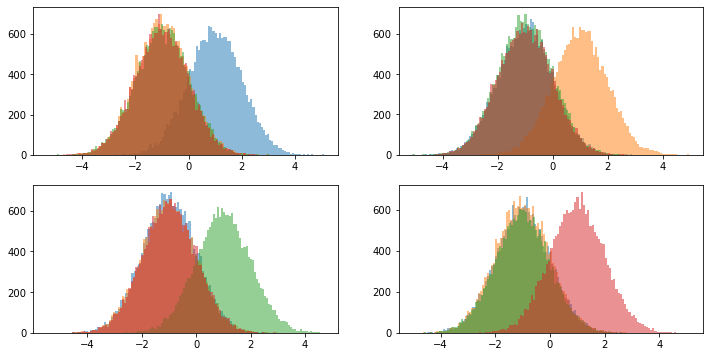

In [5]:
fig, axs = plot_scores(x, y, opts=dict(bins=100, alpha=0.5))

In [6]:
model_balanced = keras.models.Sequential([
    keras.layers.Dense(4, activation="softmax")
])
model_balanced.compile(loss="categorical_crossentropy", optimizer="Adam")
model_balanced.fit(x, y, epochs=7)

Train on 80000 samples
Epoch 1/7
80000/80000 [==============================] - 8s 94us/sample - loss: 0.6879
Epoch 2/7
80000/80000 [==============================] - 7s 89us/sample - loss: 0.4739
Epoch 3/7
80000/80000 [==============================] - 7s 90us/sample - loss: 0.4695
Epoch 4/7
80000/80000 [==============================] - 8s 101us/sample - loss: 0.4694
Epoch 5/7
80000/80000 [==============================] - 7s 93us/sample - loss: 0.4694
Epoch 6/7
80000/80000 [==============================] - 7s 92us/sample - loss: 0.4694
Epoch 7/7
80000/80000 [==============================] - 7s 91us/sample - loss: 0.4694


In [7]:
scores_balanced = model_balanced.predict(x)

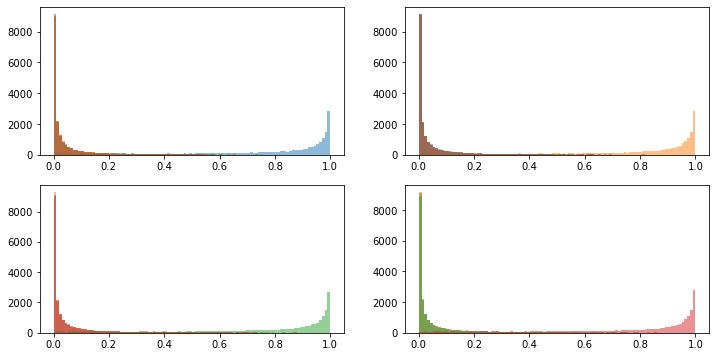

In [8]:
fig, axs = plot_scores(scores_balanced, y, opts=dict(bins=100, alpha=0.5))

In [9]:
scores_balanced_trf = transform_multiclass(scores_balanced, f_old=[1, 1, 1, 1], f_new=[1000, 100, 10, 1])

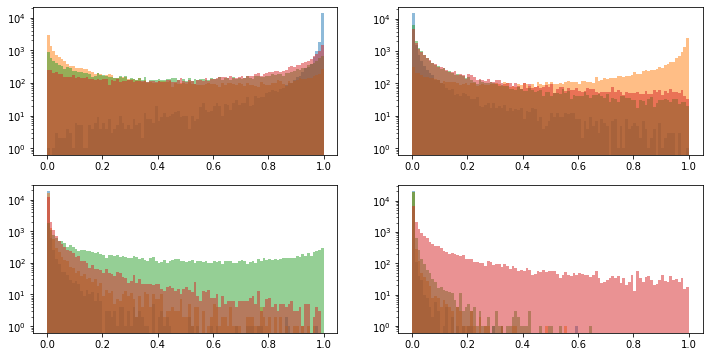

In [10]:
fig, axs = plot_scores(scores_balanced_trf, y)
for ax in np.array(axs).ravel():
    ax.set_yscale("log")

In [11]:
weights = np.ones(len(x))
weights[y[:,0]==1] = 1000
weights[y[:,1]==1] = 100
weights[y[:,2]==1] = 10
weights[y[:,3]==1] = 1
weights /= weights.mean()
model_imbalanced = keras.models.Sequential([
    keras.layers.Dense(4, activation="softmax")
])
model_imbalanced.compile(loss="categorical_crossentropy", optimizer="Adam")
model_imbalanced.fit(x, y, sample_weight=weights, epochs=10)

  ...
    to  
  ['...']
Train on 80000 samples
Epoch 1/10
80000/80000 [==============================] - 7s 90us/sample - loss: 0.5072
Epoch 2/10
80000/80000 [==============================] - 7s 83us/sample - loss: 0.1472
Epoch 3/10
80000/80000 [==============================] - 7s 86us/sample - loss: 0.1317
Epoch 4/10
80000/80000 [==============================] - 6s 81us/sample - loss: 0.1273
Epoch 5/10
80000/80000 [==============================] - 7s 83us/sample - loss: 0.1258
Epoch 6/10
80000/80000 [==============================] - 8s 95us/sample - loss: 0.1252
Epoch 7/10
80000/80000 [==============================] - 8s 96us/sample - loss: 0.1250
Epoch 8/10
80000/80000 [==============================] - 8s 100us/sample - loss: 0.1249
Epoch 9/10
80000/80000 [==============================] - 7s 90us/sample - loss: 0.1248
Epoch 10/10
80000/80000 [==============================] - 7s 92us/sample - loss: 0.1248


In [12]:
scores_imbalanced = model_imbalanced.predict(x)

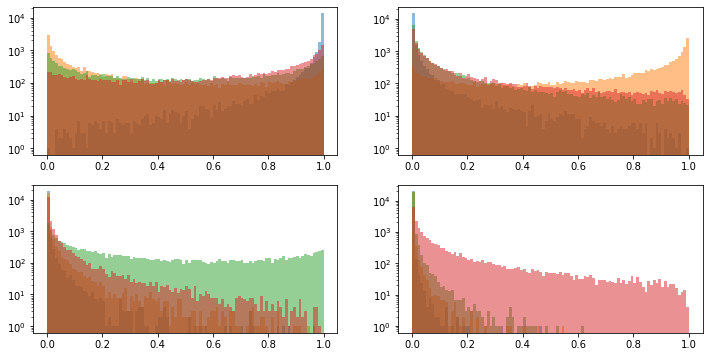

In [13]:
fig, axs = plot_scores(scores_imbalanced, y)
for ax in np.array(axs).ravel():
    ax.set_yscale("log")

In [14]:
scores_imbalanced_trf = transform_multiclass(scores_imbalanced, f_old=[1000, 100, 10, 1], f_new=[1, 1, 1, 1])

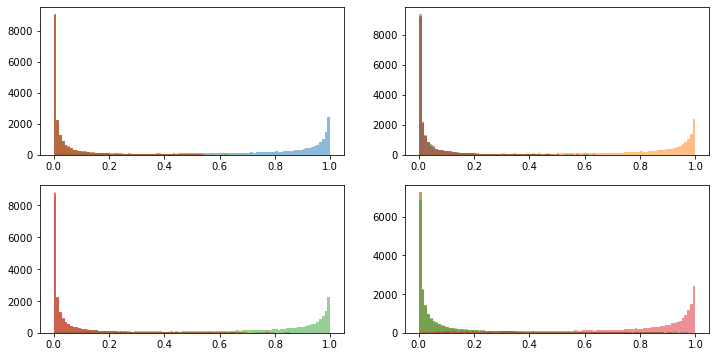

In [15]:
fig, axs = plot_scores(scores_imbalanced_trf, y, opts=dict(bins=100, alpha=0.5))